In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

# Datasets

In [2]:
# Read samples.
samples = pd.read_csv('../data/processed/sb/samples.txt', sep='\t')

# Read IM-Fusion insertions, selecting only insertions that are supported
# by at least two reads (as we did for the CTG test).
insertions_rna = (pd.read_csv('../data/processed/sb/star/insertions.txt',
                              dtype={'seqname': str}, sep='\t')
                    .query('support >= 2'))

# Read ShearSplink insertions.
insertions_dna = (pd.read_csv('../data/external/shear_splink/insertions.rbm.txt', 
                              dtype={'chromosome': str, 
                                     'position': int,
                                     'strand': int, 
                                     'support': int,
                                     'depth': int,
                                     'depth_unique': int}, sep='\t')
                    .rename(columns={'chromosome': 'seqname'}))

name_map = dict(zip(samples['short_name'], samples['sample']))
insertions_dna['sample'] = insertions_dna['sample'].map(name_map)

# Comparing insertions

In [3]:
from imfusion.expression import normalize_counts
from nbsupport import match, util
    
# Match RNA to DNA insertions.
matches = match.match_rnaseq_insertions(
    insertions_rna, insertions_dna, keep_unmatched=True)

# Drop matches without gene and matches for novel transcripts.
matches = matches.ix[~(matches['gene_id'].isnull() | 
                       matches['gene_id'].str.startswith('STRG'))]

# Annotate matches.
gtf_path = '../data/external/ensembl/Mus_musculus.GRCm38.76.gtf.gz'
genes = util.read_gtf_genes(gtf_path).set_index('id')

expr = (pd.read_csv('../data/processed/sb/star/expression.fc_gene.txt', 
                           sep='\t', comment='#')
          .drop(['Chr', 'Start', 'End', 'Strand', 'Length'], axis=1)
          .rename(columns={'Geneid': 'gene_id'})
          .set_index('gene_id')
          .rename(columns=lambda c: c.split('/')[-2])
          .pipe(normalize_counts)
          .pipe(lambda df: np.log2(df + 1)))

matches = (
    matches.pipe(match.annotate_rna_info, rna_insertions=insertions_rna)
           .pipe(match.annotate_dna_info, dna_insertions=insertions_dna)
           .pipe(match.annotate_dna_gene_distance, genes=genes)
           .pipe(match.annotate_dna_gene_position, genes=genes)
           .pipe(match.annotate_expression, expr=expr)
           .pipe(match.annotate_type))

# Map types to more readable labels.
matches['type'] = matches['type'].map({
    'shared': 'Shared',
    'dna-only': 'ShearSplink-specific',
    'rna-only': 'IM-Fusion-specific'
})

matches.head()

,rna_id,dna_id,sample,gene_id,rna_position,rna_support,dna_position,dna_support,gene_distance,dna_gene_position,expr,type
0,1566_10_11KOU023.INS_14,11KOU023.INS_1,1566_10_11KOU023,ENSMUSG00000038679,50822104.0,31.0,50807519.0,85.0,0.0,0.351887,12.526379,Shared
1,1566_10_11KOU023.INS_14,11KOU023.INS_4,1566_10_11KOU023,ENSMUSG00000038679,50822104.0,31.0,50798595.0,46.0,0.0,0.389747,12.526379,Shared
2,1566_10_11KOU023.INS_10,11KOU023.INS_3,1566_10_11KOU023,ENSMUSG00000019907,108240180.0,9.0,108240765.0,48.0,0.0,0.680402,9.932479,Shared
3,1566_10_11KOU023.INS_18,11KOU023.INS_12,1566_10_11KOU023,ENSMUSG00000035168,59646873.0,3.0,59687915.0,21.0,0.0,0.324098,9.991216,Shared
4,1566_10_11KOU023.INS_5,11KOU023.INS_8,1566_10_11KOU023,ENSMUSG00000022961,91664823.0,2.0,91665867.0,27.0,0.0,0.578951,12.058172,Shared


## Overlap

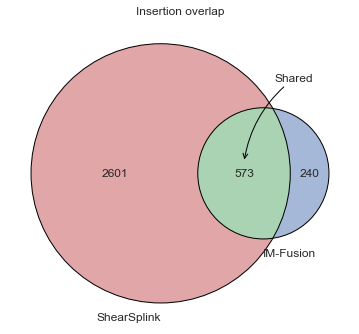

In [4]:
match.plot_insertion_overlap(matches);

In [5]:
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2, 2))
    match.plot_insertion_overlap(matches,  fontsize=5, label_offset=(25, 25),
                                 line_width=0.5, ax=ax);
    fig.savefig('../reports/figures/fig_4a_venn.pdf', bbox_inches='tight')
    plt.close(fig)

## Biases

### Insertions missed by IM-Fusion

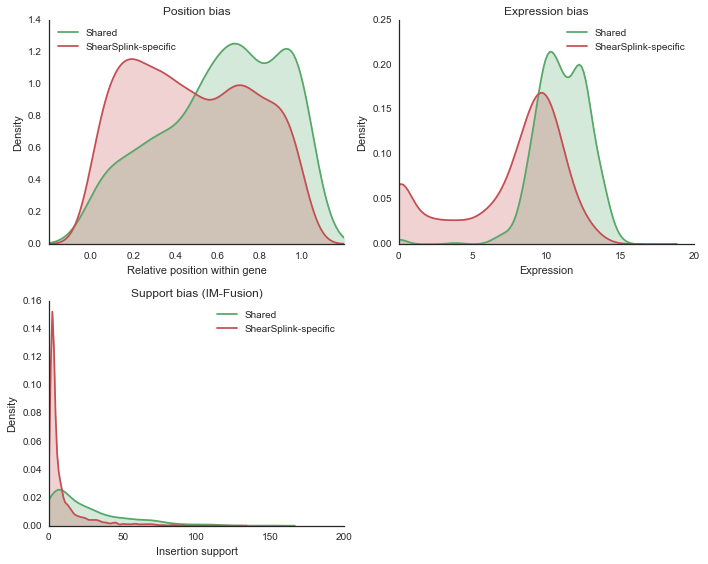

In [6]:
# Subset for Shared/DNA-specific matches.
dna_matches = matches.ix[~(matches.type == 'IM-Fusion-specific')]

# Draw plots.
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

match.plot_dna_position_bias(dna_matches, ax=axes[0, 0])
match.plot_expression_bias(dna_matches, ax=axes[0, 1])
match.plot_dna_depth_bias(dna_matches, ax=axes[1, 0])

plt.tight_layout()
axes[-1, -1].axis('off');

In [7]:
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2, 1.5))
    match.plot_dna_position_bias(dna_matches, ax=ax)
    fig.savefig('../reports/figures/fig_4b_position_bias.pdf', bbox_inches='tight')
    plt.close(fig)
    
    fig, ax = plt.subplots(figsize=(2, 1.5))
    match.plot_expression_bias(dna_matches, ax=ax)
    ax.legend().remove()
    fig.savefig('../reports/figures/fig_4c_expression_bias.pdf', bbox_inches='tight')
    plt.close(fig)
    
    fig, ax = plt.subplots(figsize=(2, 1.5))
    match.plot_dna_depth_bias(dna_matches, ax=ax)
    ax.legend().remove()
    fig.savefig('../reports/figures/fig_4d_dna_depth_bias.pdf', bbox_inches='tight')
    plt.close(fig)

In [8]:
from statsmodels.formula.api import logit

data = dna_matches[['dna_support', 'gene_distance', 'type', 'expr', 'dna_gene_position']].copy()
data['dna_gene_position'] = data['dna_gene_position']
# data['random'] = np.random.uniform(size=x.shape[0])
data['type'] = data['type'].map({'Shared': 1, 'ShearSplink-specific': 0})

# Fit model with gene distance.
model = logit('type ~ dna_support + gene_distance + expr', data)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.333668
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                 3174
Model:                          Logit   Df Residuals:                     3170
Method:                           MLE   Df Model:                            3
Date:                Sat, 04 Mar 2017   Pseudo R-squ.:                  0.2934
Time:                        15:08:20   Log-Likelihood:                -1059.1
converged:                       True   LL-Null:                       -1498.7
                                        LLR p-value:                2.641e-190
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -7.4722      0.364    -20.552      0.000      -8.185      -6.760
dna_support       0.

In [9]:
# Fit model with relative position.
model = logit('type ~ dna_support + expr + dna_gene_position', data.dropna())
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.366440
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                 2627
Model:                          Logit   Df Residuals:                     2623
Method:                           MLE   Df Model:                            3
Date:                Sat, 04 Mar 2017   Pseudo R-squ.:                  0.2928
Time:                        15:08:20   Log-Likelihood:                -962.64
converged:                       True   LL-Null:                       -1361.1
                                        LLR p-value:                1.967e-172
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -8.2323      0.398    -20.687      0.000      -9.012      -7.452
dna_supp

### Insertions missed by ShearSplink

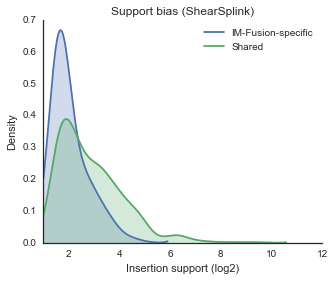

In [10]:
from copy import deepcopy

# Select RNA insertions.
rna_matches = matches.ix[~(matches.type == 'ShearSplink-specific')]

# Plot insertion depth.
fig, ax = plt.subplots(figsize=(5, 4))
match.plot_rna_depth_bias(rna_matches, ax=ax);

# TODO: Transposon feature.

In [11]:
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2, 1.5))
    match.plot_rna_depth_bias(rna_matches, ax=ax)
    fig.savefig('../reports/figures/fig_4e_rna_depth_bias.pdf', bbox_inches='tight')
    plt.close(fig)

In [12]:
data = rna_matches[['rna_support', 'type']].copy()
data['type'] = data['type'].map({'Shared': 1, 'IM-Fusion-specific': 0})

model = logit('type ~ rna_support', data)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.545435
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                  813
Model:                          Logit   Df Residuals:                      811
Method:                           MLE   Df Model:                            1
Date:                Sat, 04 Mar 2017   Pseudo R-squ.:                  0.1010
Time:                        15:08:21   Log-Likelihood:                -443.44
converged:                       True   LL-Null:                       -493.28
                                        LLR p-value:                 1.783e-23
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0624      0.132     -0.471      0.638      -0.322       0.197
rna_support     0.1763    

# CTG comparison

In [13]:
# Read RNA CTGs.
rna_ctgs = (pd.read_csv('../data/processed/sb/star/ctgs.txt', sep='\t')
              .sort_values(['n_samples'], ascending=False))

# Read DNA CTGs.
dna_hits = (pd.read_csv('../data/external/shear_splink/insertions.cis.rbm.txt', sep='\t')
              .groupby('gene_name')['sample'].nunique().reset_index()
              .sort_values('sample', ascending=False))

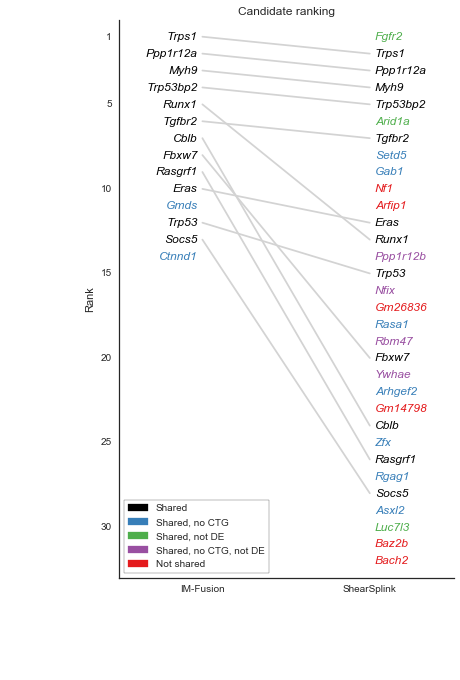

In [18]:
import toolz
from nbsupport import rank
from imfusion.expression import read_exon_counts
        
# Read counts and create gene_id --> gene_name map needed for annotate_de.
exon_counts = read_exon_counts('../data/processed/sb/star/expression.txt')

gene_id_map = toolz.merge(
     dict(zip(insertions_dna['gene_name'], insertions_dna['gene_id'])),
     dict(zip(insertions_rna['gene_name'], insertions_rna['gene_id'])))

# Compare and annotate rankings.
ranks = (
    rank.compare_ranks(rna_ctgs.query('de_pvalue < 0.05'), 
                       dna_hits, suffixes=('_rna', '_dna'))
        .pipe(rank.annotate_ctg, ctgs=rna_ctgs, col_name='ctg_rna')
        .pipe(rank.annotate_ctg, ctgs=dna_hits, col_name='ctg_dna')
        .pipe(rank.annotate_ins, insertions=insertions_rna, col_name='ins_rna')
        .pipe(rank.annotate_ins, insertions=insertions_dna, col_name='ins_dna')
        .pipe(rank.annotate_de, insertions=insertions_rna, 
              exon_counts=exon_counts, gene_id_map=gene_id_map,
              col_name='is_de', fallback_to_gene=True)
        .pipe(rank.annotate_type))
    
# Plot ranking.
order = rank.RANK_TYPES
palette = (['black'] + sns.color_palette('Set1')[1:4] + 
           [sns.color_palette('Set1')[0]])

fig, ax = plt.subplots(figsize=(6, 10)) 
rank.plot_ranks(ranks, rank_a='rank_rna', rank_b='rank_dna',
                label='gene_name', hue='type', ax=ax,
                palette=palette, order=order,
                legend_kws={'frameon': True, 
                            'loc': 'lower left'},
                label_kws={'fontstyle': 'italic'})
ax.set_xticklabels(['IM-Fusion', 'ShearSplink']);
ax.set_title('Candidate ranking')

In [19]:
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2.2, 4.2)) 
    rank.plot_ranks(ranks, rank_a='rank_rna', rank_b='rank_dna',
                    label='gene_name', hue='type', ax=ax,
                    palette=palette, order=order,
                    legend_kws={'frameon': False, 
                                'loc': 'lower left'},
                    label_kws={'fontstyle': 'italic'})
    ax.set_xlim(-0.9, 1.9)
    ax.set_xticklabels(['IM-Fusion', 'ShearSplink'])
    ax.set_title('Candidate ranking')

    fig.savefig('../reports/figures/fig_4f_ctg_ranks.pdf', bbox_inches='tight')
    plt.close(fig)

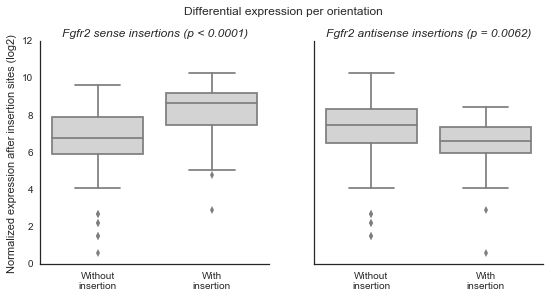

In [16]:
from imfusion.model import Insertion
from nbsupport import insertions as nb_ins

insertion_objs = list(Insertion.from_frame(insertions_rna))

# Determine sample sets.
sense_samples = set(insertions_rna.query(
    'gene_name == "Fgfr2" and orientation == "sense"')['sample'])

antisense_samples = set(insertions_rna.query(
    'gene_name == "Fgfr2" and orientation == "antisense"')['sample'])


# Plot stratified DE.
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

nb_ins.plot_de(insertion_objs, exon_counts, gene_id='ENSMUSG00000030849',
               gene_name='Fgfr2', pos_samples=sense_samples, ax=axes[0])
axes[0].set_title('Fgfr2 sense insertions (p < 0.0001)')

nb_ins.plot_de(insertion_objs, exon_counts, gene_id='ENSMUSG00000030849',
               gene_name='Fgfr2', pos_samples=antisense_samples, ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_title('Fgfr2 antisense insertions (p = 0.0062)')

sns.despine()

fig.suptitle('Differential expression per orientation', y=1.02)

# Plot again for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    fig, axes = plt.subplots(ncols=2, figsize=(4, 2), sharey=True)

    nb_ins.plot_de(insertion_objs, exon_counts, gene_id='ENSMUSG00000030849',
                   gene_name='Fgfr2', pos_samples=sense_samples, ax=axes[0])
    axes[0].set_title('Fgfr2 sense insertions (p < 0.0001)')

    nb_ins.plot_de(insertion_objs, exon_counts, gene_id='ENSMUSG00000030849',
                   gene_name='Fgfr2', pos_samples=antisense_samples, ax=axes[1])
    axes[1].set_ylabel('')
    axes[1].set_title('Fgfr2 antisense insertions (p = 0.0062)')

    sns.despine()

    fig.suptitle('Differential expression per orientation', y=1.04, fontsize=7)
    
    fig.savefig('../reports/supplemental/figures/fig_sy_fgfr2_de.pdf', bbox_inches='tight')
    plt.close(fig)

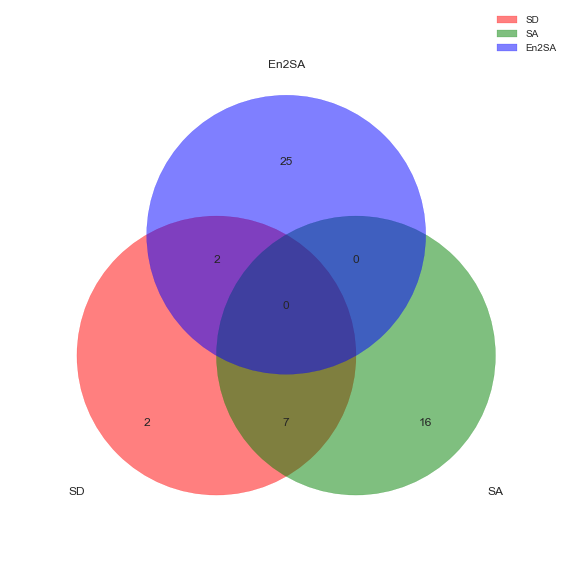

In [17]:
from nbsupport.venn import venn

fgfr2_grps = {key: set(grp['sample']) for key, grp in 
              (insertions_rna.query('gene_name == "Fgfr2"')
                             .groupby('feature_name'))}

venn(list(fgfr2_grps.values()), names=list(fgfr2_grps.keys()));


# Plot again for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    fig = venn(list(fgfr2_grps.values()), 
               names=list(fgfr2_grps.keys()), figsize=(4, 2.8))
    fig.suptitle('Feature overlap', fontsize=7, y=0.9)
    fig.savefig('../reports/supplemental/figures/fig_sy_fgfr2_venn.pdf', bbox_inches='tight')
    plt.close(fig)